In [1]:
!pip install monai

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [2]:
#This is so that the plots are there along with the code in the notebook rather than a popup
%matplotlib inline

import os
from os.path import isfile,join
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
import torchvision.transforms as T
from torch.nn.modules import padding
from scipy.ndimage import distance_transform_edt
from monai.metrics import HausdorffDistanceMetric,SurfaceDistanceMetric
import math

In [3]:
# For reproducing results
seed = 58
#random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## Getting Data

In [4]:
# GPU | CPU
def get_default_device():
    
    if torch.cuda.is_available():
        return torch.device('cuda:0')
    else:
        return torch.device('cpu')

def to_device(data,device):
    
    if isinstance(data,(list,tuple)):
        return [to_device(x,device) for x in data]
    
    return data.to(device,non_blocking = True)

In [5]:
''' ----------------------------------------------------------
    All the content here is intermediate data used to obtain df
    None of these will be referenced later in the notebook 
    ---------------------------------------------------------- '''

base_path = "../processed/"

file_names = {"image": "img_crp_v2.npy", 
              "esophagus": "/structure/Esophagus_crp_v2.npy",
              "heart": "/structure/Heart_crp_v2.npy",
              "lung_L": "/structure/Lung_L_crp_v2.npy",
              "lung_R": "/structure/Lung_R_crp_v2.npy",
              "spinal_cord": "/structure/SpinalCord_crp_v2.npy"} 

dirs = [(base_path + f + "/") for f in os.listdir(base_path) if not isfile(join(base_path,f))]

data = [[f + file_names["image"],
         f + file_names["esophagus"],
         f + file_names["heart"],
         f + file_names["lung_L"],
         f + file_names["lung_R"],
         f + file_names["spinal_cord"]] for f in dirs]


In [6]:
#df contains all data regarding input data
df = pd.DataFrame(data, columns = ['Image','Esophagus','Heart','Lung_L','Lung_R','SpinalCord'])
df.head()

Image  \
0  processed/LCTSC-Train-S3-005/img_crp_v2.npy   
1  processed/LCTSC-Train-S1-004/img_crp_v2.npy   
2  processed/LCTSC-Train-S2-004/img_crp_v2.npy   
3  processed/LCTSC-Train-S3-008/img_crp_v2.npy   
4  processed/LCTSC-Train-S3-012/img_crp_v2.npy   

                                           Esophagus  \
0  processed/LCTSC-Train-S3-005//structure/Esopha...   
1  processed/LCTSC-Train-S1-004//structure/Esopha...   
2  processed/LCTSC-Train-S2-004//structure/Esopha...   
3  processed/LCTSC-Train-S3-008//structure/Esopha...   
4  processed/LCTSC-Train-S3-012//structure/Esopha...   

                                               Heart  \
0  processed/LCTSC-Train-S3-005//structure/Heart_...   
1  processed/LCTSC-Train-S1-004//structure/Heart_...   
2  processed/LCTSC-Train-S2-004//structure/Heart_...   
3  processed/LCTSC-Train-S3-008//structure/Heart_...   
4  processed/LCTSC-Train-S3-012//structure/Heart_...   

                                              Lung_L  \
0  processed/LCTSC-Train-S3-005//structure/Lung_L...   
1  processed/LCTSC-Train-S1-004//structure/Lung_L...   
2  processed/LCTSC-Train-S2-004//structure/Lung_L...   
3  processed/LCTSC-Train-S3-008//structure/Lung_L...   
4  processed/LCTSC-Train-S3-012//structure/Lung_L...   

                                              Lung_R  \
0  processed/LCTSC-Train-S3-005//structure/Lung_R...   
1  processed/LCTSC-Train-S1-004//structure/Lung_R...   
2  processed/LCTSC-Train-S2-004//structure/Lung_R...   
3  processed/LCTSC-Train-S3-008//structure/Lung_R...   
4  processed/LCTSC-Train-S3-012//structure/Lung_R...   

                                          SpinalCord  
0  processed/LCTSC-Train-S3-005//structure/Spinal...  
1  processed/LCTSC-Train-S1-004//structure/Spinal...  
2  processed/LCTSC-Train-S2-004//structure/Spinal...  
3  processed/LCTSC-Train-S3-008//structure/Spinal...  
4  processed/LCTSC-Train-S3-012//structure/Spinal...

## Datagen

In [7]:
def Datagen_CT(df,img_size,seg_organ,window_size):

    for _, row in df.iterrows():

        image = np.load(row["Image"])
        image = np.moveaxis(image,0,-1)
        image = cv2.resize(image, (img_size,img_size))
        image = np.swapaxes(image,0,-1)

        mask = np.load(row[seg_organ])
        mask = np.moveaxis(mask,0,-1)
        mask = cv2.resize(mask , (img_size,img_size))
        mask = np.swapaxes(mask,0,-1)

        #Padding to fit window_size
        image = np.concatenate((np.zeros((int(window_size/2),img_size,img_size)),image))
        image = np.concatenate((image,np.zeros((int(window_size/2),img_size,img_size))))
        mask = np.concatenate((np.zeros((int(window_size/2),img_size,img_size)),mask))
        mask = np.concatenate((mask,np.zeros((int(window_size/2),img_size,img_size))))

        half_window = window_size//2
        slice_index = half_window + 1 #the index of the next slice to be examined

        while slice_index + window_size + half_window - 1 <= image.shape[0]:
            images = image[slice_index - half_window : slice_index + window_size + half_window,:,:]
            masks = mask[slice_index: slice_index + window_size,:,:]

            slice_index = slice_index + window_size
            images = np.expand_dims(images,axis=1).astype('float32')
            masks = np.expand_dims(masks,axis=1).astype('float32')

            yield images, masks


## Model

In [8]:
class AttentionHead(nn.Module):
    def __init__(self,dim_in,dim_q,dim_k):
        super(AttentionHead,self).__init__()
        self.q = nn.Linear(dim_in,dim_q)
        self.k = nn.Linear(dim_in,dim_k)
        self.v = nn.Linear(dim_in,dim_k)
        self.linear = nn.Linear(dim_k,dim_in)

    def forward(self,query,key,value):
        query = self.q(query)
        key = self.k(key)
        value = self.v(value)

        temp = query.matmul(key.transpose(0,1))
        scale = query.size(-1) ** 0.5 #feature dimension
        softmax = F.softmax(temp/scale, dim=-1)
        attn_mat = softmax.matmul(value)
        return self.linear(attn_mat) 

In [9]:
#Input size is (window_size, 1, 512, 512)
class UNet(nn.Module):

    def __init__(self):
        super(UNet,self).__init__()

        self.conv1 = nn.Conv2d(1,32,3,padding="same")
        self.conv2 = nn.Conv2d(32,32,3,padding="same")

        self.conv3 = nn.Conv2d(32,64,3,padding="same")
        self.conv4 = nn.Conv2d(64,64,3,padding="same")

        self.conv5 = nn.Conv2d(64,128,3,padding="same")
        self.conv6 = nn.Conv2d(128,128,3,padding="same")

        self.conv7 = nn.Conv2d(128,256,3,padding="same")
        self.conv8 = nn.Conv2d(256,256,3,padding="same")

        self.conv9 = nn.Conv2d(256,512,3,padding="same")
        self.conv10 = nn.Conv2d(512,512,3,padding="same")

        self.conv11 = nn.Conv2d(512,1024,3,padding="same")
        self.conv12 = nn.Conv2d(1024,1024,3,padding="same")

        #since last two maxpools are x4, the filter and strides of first two transpose convs are 4 each
        self.trans_conv1 = nn.ConvTranspose2d(1024,512,kernel_size=4,stride=4)
        self.conv_r10 = nn.Conv2d(1024,512,kernel_size=3,padding="same")
        self.conv_r9 = nn.Conv2d(512,512,kernel_size=3,padding="same")

        self.trans_conv2 = nn.ConvTranspose2d(512,256,kernel_size=4,stride=4)
        self.conv_r8 = nn.Conv2d(512,256,kernel_size=3,padding="same")
        self.conv_r7 = nn.Conv2d(256,256,kernel_size=3,padding="same")

        self.trans_conv3 = nn.ConvTranspose2d(256,128,kernel_size=2,stride=2)
        self.conv_r6 = nn.Conv2d(256,128,kernel_size=3,padding="same")
        self.conv_r5 = nn.Conv2d(128,128,kernel_size=3,padding="same")

        self.trans_conv4 = nn.ConvTranspose2d(128,64,kernel_size=2,stride=2)
        self.conv_r4 = nn.Conv2d(128,64,kernel_size=3,padding="same")
        self.conv_r3 = nn.Conv2d(64,64,kernel_size=3,padding="same")

        self.trans_conv5 = nn.ConvTranspose2d(64,32,kernel_size=2,stride=2)
        self.conv_r2 = nn.Conv2d(64,32,kernel_size=3,padding="same")
        self.conv_r1 = nn.Conv2d(32,32,kernel_size=3,padding="same")

        self.conv_f = nn.Conv2d(32,1,kernel_size=1)

        self.maxpool = nn.MaxPool2d((2,2))
        self.maxpool_x4 = nn.MaxPool2d((4,4))

        self.attn_head1 = AttentionHead(dim_in=16384,dim_q=8192,dim_k=8192)
        # self.attn_head2 = AttentionHead(dim_in=16384,dim_q=8192,dim_k=8192)
        # self.attn_head3 = AttentionHead(dim_in=16384,dim_q=8192,dim_k=8192)

  
    def attention_layer_calc(self,x_flatten,window_size):

        i = 0
        x_attn = None

        while i + window_size <= x_flatten.shape[0]:
            img_enc = x_flatten[i:i+window_size]
            pos_enc = np.zeros(img_enc.shape)
            emb_length = pos_enc.shape[1]

            #calculating the value of positional embedding
            for ind1 in range(pos_enc.shape[0]):
                for ind2 in range(pos_enc.shape[1]):

                    pos_enc_val = ind1/(10000**(2*ind2/emb_length))
                    if ind1%2 == 0:
                        pos_enc[ind1][ind2] = np.sin(pos_enc_val)
                    else:
                        pos_enc[ind1][ind2] = np.cos(pos_enc_val)
      
            pos_enc = to_device(torch.from_numpy(pos_enc.astype('float32')), get_default_device())
            img_enc = img_enc + pos_enc

            temp1 = self.attn_head1(img_enc,img_enc,img_enc)[window_size//2][None,:]
            # temp2 = self.attn_head2(temp1,temp1,temp1)
            # temp3 = self.attn_head3(temp2,temp2,temp2)[window_size//2][None,:]

            i = i + 1
            if x_attn is None:
                print("TEMP1: ",temp1.shape)
                x_attn = temp1
            else:
                x_attn = torch.cat((x_attn,temp1))
                print("x_attn: ",x_attn.shape)

        x_attn = x_attn.reshape([x_attn.shape[0],1024,4,4])
        return x_attn


    def forward(self,x,window_size): #note: the entire batch is passed in 

        x1 = self.conv1(x)
        x1 = F.relu(x1)
        x1 = self.conv2(x1)
        x1 = F.relu(x1)

        x2 = self.maxpool(x1)
        x2 = self.conv3(x2)
        x2 = F.relu(x2)
        x2 = self.conv4(x2)
        x2 = F.relu(x2)

        x3 = self.maxpool(x2)
        x3 = self.conv5(x3)
        x3 = F.relu(x3)
        x3 = self.conv6(x3)
        x3 = F.relu(x3)

        x4 = self.maxpool(x3)
        x4 = self.conv7(x4)
        x4 = F.relu(x4)
        x4 = self.conv8(x4)
        x4 = F.relu(x4)

        x5 = self.maxpool_x4(x4)
        x5 = self.conv9(x5)
        x5 = F.relu(x5)
        x5 = self.conv10(x5)
        x5 = F.relu(x5)

        x6 = self.maxpool_x4(x5)
        x6 = self.conv11(x6)
        x6 = F.relu(x6)
        x6 = self.conv12(x6)
        x6 = F.relu(x6) #Size: 4x4x1024

        #Attention
        x_flatten = torch.flatten(x6,start_dim=1)
        x_attn = self.attention_layer_calc(x_flatten,window_size)

        #expansion
        xi_5 = self.trans_conv1(x_attn)
        xi_5 = torch.cat((xi_5,x5[(window_size//2):-(window_size//2)]),dim=1) #concatenating to the channel dimension
        xi_5 = self.conv_r10(xi_5)
        xi_5 = F.relu(xi_5)
        xi_5 = self.conv_r9(xi_5)
        xi_5 = F.relu(xi_5)

        xi_4 = self.trans_conv2(xi_5)
        xi_4 = torch.cat((xi_4,x4[(window_size//2):-(window_size//2)]),dim=1) 
        xi_4 = self.conv_r8(xi_4)
        xi_4 = F.relu(xi_4)
        xi_4 = self.conv_r7(xi_4)
        xi_4 = F.relu(xi_4)

        xi_3 = self.trans_conv3(xi_4)
        xi_3 = torch.cat((xi_3,x3[(window_size//2):-(window_size//2)]), dim=1)
        xi_3 = self.conv_r6(xi_3)
        xi_3 = F.relu(xi_3)
        xi_3 = self.conv_r5(xi_3)
        xi_3 = F.relu(xi_3)

        xi_2 = self.trans_conv4(xi_3)
        xi_2 = torch.cat((xi_2,x2[(window_size//2):-(window_size//2)]), dim=1)
        xi_2 = self.conv_r4(xi_2)
        xi_2 = F.relu(xi_2)
        xi_2 = self.conv_r3(xi_2)
        xi_2 = F.relu(xi_2)

        xi_1 = self.trans_conv5(xi_2)
        xi_1 = torch.cat((xi_1,x1[(window_size//2):-(window_size//2)]), dim=1)
        xi_1 = self.conv_r2(xi_1)
        xi_1 = F.relu(xi_1)
        xi_1 = self.conv_r1(xi_1)
        xi_1 = F.relu(xi_1)

        xf = self.conv_f(xi_1)
        xf = torch.sigmoid(xf)


        return xf

## Loss Function

In [10]:
def dice_loss(y_pred,y_true,smooth=1):
    
    print("YPRED: ",y_pred.shape)
    print("YTRUE: ",y_true.shape)
    
    y_true_f = torch.flatten(y_true,start_dim=1)
    y_pred_f = torch.flatten(y_pred,start_dim=1)

    intersection = torch.sum(y_true_f * y_pred_f,1)
    result = torch.log((2. * intersection + smooth) / (torch.sum(y_true_f,1) + torch.sum(y_pred_f,1) + smooth))
    dice_loss = -1 * torch.sum(result)/y_pred.shape[0]
    return  dice_loss

## Eval Metrics

In [11]:
#IOU [Between 0-1: Higher value => Better results]
def iou_metric(y_pred,y_true,smooth=1):
    y_true_f = torch.flatten(y_true,start_dim=1)
    y_pred_f = torch.flatten(y_pred,start_dim=1)

    intersection = torch.sum(y_true_f * y_pred_f,1)
    union = torch.sum(y_true_f,1) + torch.sum(y_pred_f,1) - torch.sum(y_true_f * y_pred_f,1)
    iou_score = torch.sum((intersection + smooth)/(union + smooth)) / y_pred.shape[0]
    return  iou_score

#Dice [Between 0-1: Higher value => Better results]
def dice_metric(y_pred,y_true,smooth=1):
    y_true_f = torch.flatten(y_true,start_dim=1)
    y_pred_f = torch.flatten(y_pred,start_dim=1)

    intersection = torch.sum(y_true_f * y_pred_f,1)
    result = torch.sum((2. * intersection + smooth) / (torch.sum(y_true_f,1) + torch.sum(y_pred_f,1) + smooth))
    dice_score = result/y_pred.shape[0]
    return  dice_score

#MSD [Between 0-infinity: Smaller value => Better results]
def msd_metric(y_pred,y_true):
    y_pred[y_pred >= 0.5] = 1
    y_pred[y_pred < 0.5] = 0

    msd = SurfaceDistanceMetric(include_background=True)
    val = torch.sum(msd(y_pred,y_true))

    if val.isnan():
    return to_device(torch.tensor(0),get_default_device())

    return val

#HD95 [Between 0-infinity: Smaller value => Better results]
def hd95_metric(y_pred,y_true):
    y_pred[y_pred >= 0.5] = 1
    y_pred[y_pred < 0.5] = 0

    hd = HausdorffDistanceMetric(percentile=95,reduction="none",include_background=False)
    val = torch.sum(hd(y_pred,y_true))

    if val.isnan():
        return to_device(torch.tensor(0),get_default_device())

    return val

#Precision [Between 0-1: Larger value => Better results]
def precision_metric(y_pred,y_true):
    y_true = torch.flatten(y_true,start_dim=1)
    y_pred = torch.flatten(y_pred,start_dim=1)

    y_pred[y_pred > 0] = 1
    y_pred[y_pred <= 0] = 0

    tp = torch.sum(y_pred * y_true,1)
    fp = torch.sum(y_pred * (1 - y_true),1)

    if 0 in tp+fp:
    return to_device(torch.tensor(0),get_default_device())

    precision = torch.sum(tp/(tp+fp))/y_pred.shape[0]
    return precision

#Recall [Between 0-1: Larger value => Better results]
def recall_metric(y_pred,y_true):
    y_true = torch.flatten(y_true,start_dim=1)
    y_pred = torch.flatten(y_pred,start_dim=1)

    y_pred[y_pred > 0] = 1
    y_pred[y_pred <= 0] = 0

    tp = torch.sum(y_pred * y_true,1)
    fn = torch.sum((1-y_pred) * y_true,1)

    if 0 in tp+fn:
    return to_device(torch.tensor(0),get_default_device())

    recall = torch.sum(tp/(tp+fn))/y_pred.shape[0]
    return recall

## Eval Function

In [12]:
def eval(model,test_df,img_size,seg_organ,window_size,epoch=0,epochs=0):
    #epoch and epoch size is passed if this function is called during training in between epochs
    model.eval()
    test_dataloader = Datagen_CT(df=test_df,img_size=img_size,seg_organ=seg_organ,window_size=window_size)

    iou_val = 0
    dice_val = 0
    msd_val = 0
    hd95_val = 0
    pre_val = 0
    re_val = 0

    count = 0
    for batch_idx, (X,y) in enumerate(test_dataloader):
        X = to_device(torch.tensor(X, requires_grad=True),get_default_device())
        y = to_device(torch.tensor(y, requires_grad=True),get_default_device())

        output = model(X,window_size)
        iou_val += iou_metric(output,y).item()
        dice_val += dice_metric(output,y).item()
        # msd_val += msd_metric(output,y).item()
        # hd95_val += hd95_metric(output,y).item()
        pre_val += precision_metric(output,y).item()
        re_val += recall_metric(output,y).item()

        count = count + 1
        break #<<<<<-------------REMOVE THIS

    print('-------------------------')
    print('Epoch [{}/{}]   Dice Metric: {:.4f}  IoU Metric: {:.4f}  \n  Precision Metric: {:.4f}  Recall Metric: {:.4f}'.format(epoch+1,epochs,dice_val/count,iou_val/count,pre_val/count,re_val/count))
    print('\n')

## Fit Function

In [13]:
def fit(model,img_size,seg_organ,window_size,loss_fn,optimizer,scheduler,epochs,train_df,test_df,validate=False,print_every=1):


    for epoch in range(epochs):

        model.train()
        train_dataloader = Datagen_CT(df=train_df,img_size=img_size,seg_organ=seg_organ,window_size=window_size)
    
        for batch_idx, (X,y) in enumerate(train_dataloader):
            X = to_device(torch.tensor(X, requires_grad=True),get_default_device())
            y = to_device(torch.tensor(y, requires_grad=True),get_default_device())

            optimizer.zero_grad()
            output = model(X,window_size)
            loss = loss_fn(output,y)
            loss.backward()
            optimizer.step()

            if batch_idx % print_every == 0:
                print('Epoch [{}/{}]   Batch {}   Loss: {:.4f}    Max: {:.4f}'.format(epoch+1,epochs,batch_idx,loss.item(),torch.max(output)))

        

                plt.subplot(1,3,1)
                plt.imshow(X.cpu().detach().numpy()[window_size//2][0])

                plt.subplot(1,3,2)
                plt.imshow(y.cpu().detach().numpy()[0][0])

                plt.subplot(1,3,3)
                plt.imshow(output.cpu().detach().numpy()[0][0])

                plt.show()
            
            break #<<<<<-------------REMOVE THIS


        print('Epoch [{}/{}]   Batch {}   Loss: {:.4f}    lr: {:.10f}'.format(epoch+1,epochs,batch_idx,loss.item(),optimizer.param_groups[0]['lr']))
        scheduler.step()

        if validate:
            eval(model=model,test_df=test_df,img_size=img_size,seg_organ=seg_organ,window_size=window_size,epoch=epoch,epochs=epochs)


## Training

In [14]:
#Parameters
img_size = 512
epochs = 10
seg_organ = 'Lung_L'
train_test_split = 0.8
window_size = 5

#Model Specific
train_df = df[:int(train_test_split*df.shape[0])].reset_index(drop=True)
test_df = df[int(train_test_split*df.shape[0]):].reset_index(drop=True)

model = UNet()
model = to_device(model,get_default_device())
loss_fn = dice_loss
optimizer = torch.optim.Adam(model.parameters(),lr=0.000005)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[2,6,10], gamma=0.1)

Epoch [1/10]   Batch 0   Loss: 10.9528    Max: 0.5099


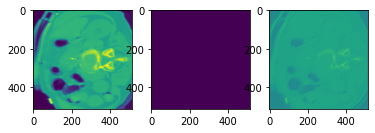

Epoch [1/10]   Batch 50   Loss: 1.0905    Max: 0.5092


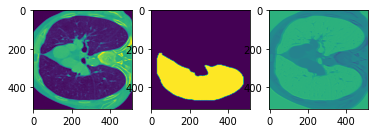

Epoch [1/10]   Batch 100   Loss: 10.9504    Max: 0.5090


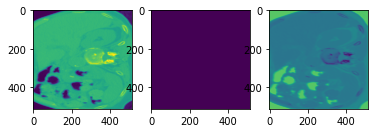

Epoch [1/10]   Batch 150   Loss: 10.9488    Max: 0.5076


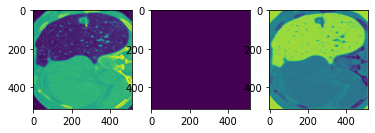

Epoch [1/10]   Batch 200   Loss: 10.9446    Max: 0.5076


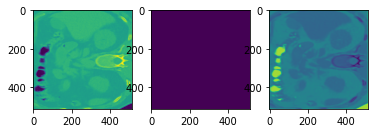

Epoch [1/10]   Batch 250   Loss: 1.2035    Max: 0.5073


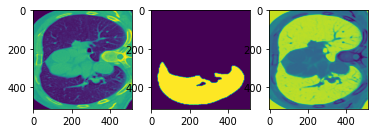

Epoch [1/10]   Batch 300   Loss: 1.5676    Max: 0.5073


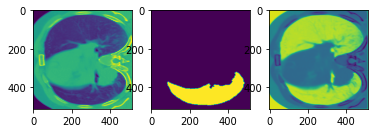

Epoch [1/10]   Batch 350   Loss: 1.2885    Max: 0.5076


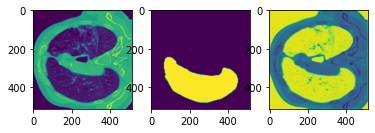

Epoch [1/10]   Batch 400   Loss: 3.6885    Max: 0.5076


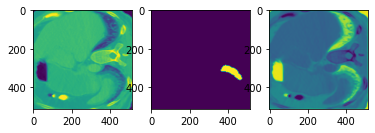

Epoch [1/10]   Batch 450   Loss: 2.3541    Max: 0.5071


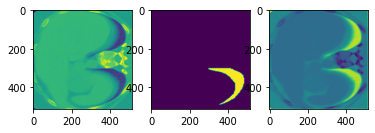

Epoch [1/10]   Batch 500   Loss: 10.9146    Max: 0.5074


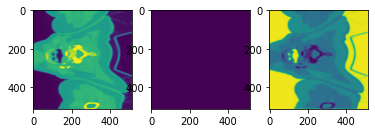

Epoch [1/10]   Batch 550   Loss: 10.8566    Max: 0.5070


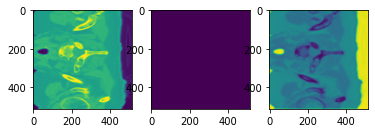

Epoch [1/10]   Batch 600   Loss: 10.4451    Max: 0.5044


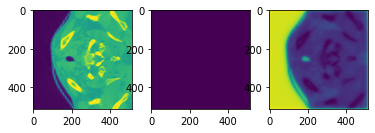

Epoch [1/10]   Batch 650   Loss: 2.5249    Max: 0.4548


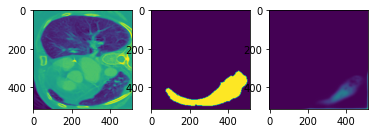

Epoch [1/10]   Batch 700   Loss: 0.9341    Max: 0.4819


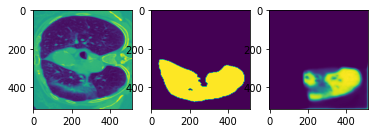

Epoch [1/10]   Batch 750   Loss: 2.3100    Max: 0.4302


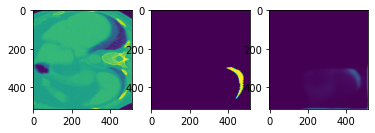

Epoch [1/10]   Batch 800   Loss: 1.3422    Max: 0.4857


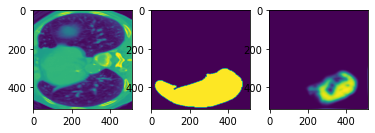

Epoch [1/10]   Batch 850   Loss: 2.0610    Max: 0.3892


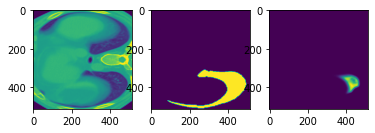

Epoch [1/10]   Batch 900   Loss: 1.8341    Max: 0.5001


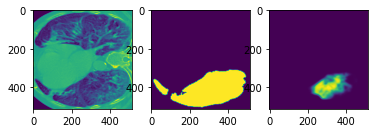

Epoch [1/10]   Batch 950   Loss: 1.5760    Max: 0.5027


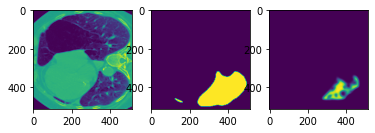

Epoch [1/10]   Batch 1000   Loss: 1.0628    Max: 0.4997


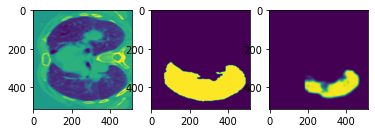

Epoch [1/10]   Batch 1050   Loss: 2.3221    Max: 0.4990


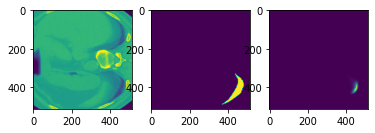

Epoch [1/10]   Batch 1100   Loss: 2.1609    Max: 0.3157


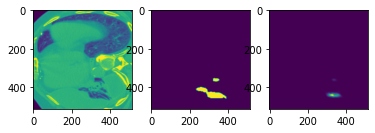

Epoch [1/10]   Batch 1150   Loss: 1.3171    Max: 0.5098


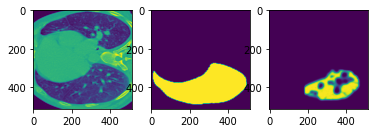

Epoch [1/10]   Batch 1200   Loss: 0.7045    Max: 0.5167


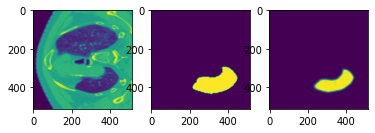

Epoch [1/10]   Batch 1208   Loss: 6.7790    lr: 0.0000050000


/opt/conda/lib/python3.8/site-packages/monai/metrics/surface_distance.py:153: UserWarning: the ground truth of class 0 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/opt/conda/lib/python3.8/site-packages/monai/metrics/surface_distance.py:155: UserWarning: the prediction of class 0 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/opt/conda/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:158: UserWarning: the ground truth of class 0 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/opt/conda/lib/python3.8/site-packages/monai/metrics/hausdorff_distance.py:160: UserWarning: the prediction of class 0 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} i

1
2
3
4
5
6


/opt/conda/lib/python3.8/site-packages/numpy/lib/function_base.py:4009: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
-------------------------
Epoch [1/10]   Dice Metric: 0.4286  IoU Metric: 0.3384  MSD Metric: inf  
  HD95 Metric: 398.2702  Precision Metric: 0.5600  Recall Metric: 0.2141


Epoch [2/10]   Batch 0   Loss: 6.1032    Max: 0.5179


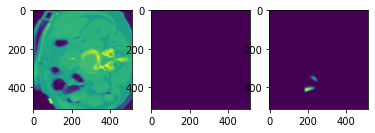

Epoch [2/10]   Batch 50   Loss: 1.1232    Max: 0.5172


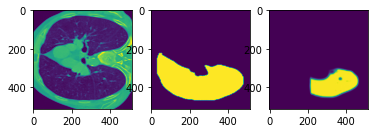

Epoch [2/10]   Batch 100   Loss: 0.1186    Max: 0.0026


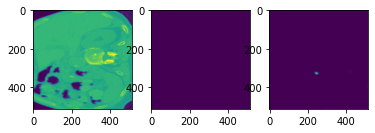

Epoch [2/10]   Batch 150   Loss: -0.0000    Max: 0.0000


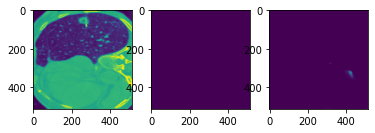

Epoch [2/10]   Batch 200   Loss: 0.0149    Max: 0.0000


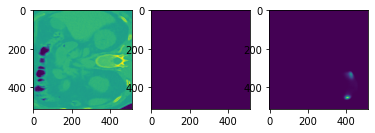

Epoch [2/10]   Batch 250   Loss: 1.1621    Max: 0.5358


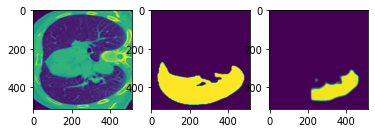

Epoch [2/10]   Batch 300   Loss: 0.8498    Max: 0.5495


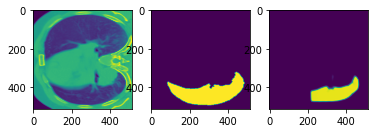

Epoch [2/10]   Batch 350   Loss: 0.9889    Max: 0.5420


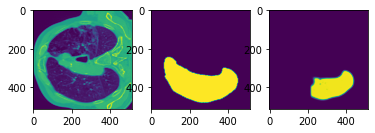

Epoch [2/10]   Batch 400   Loss: 2.2253    Max: 0.5324


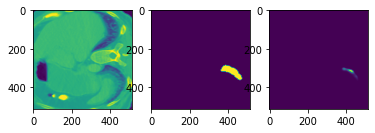

Epoch [2/10]   Batch 450   Loss: 0.8540    Max: 0.6397


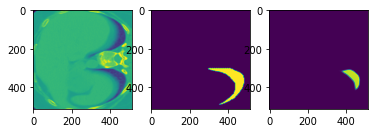

Epoch [2/10]   Batch 500   Loss: 7.0464    Max: 0.6048


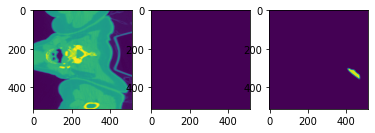

Epoch [2/10]   Batch 550   Loss: 4.1685    Max: 0.6616


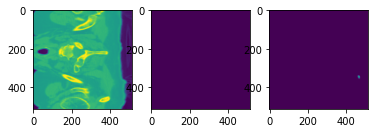

Epoch [2/10]   Batch 600   Loss: 0.0125    Max: 0.0012


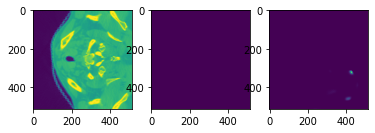

Epoch [2/10]   Batch 650   Loss: 0.8931    Max: 0.6869


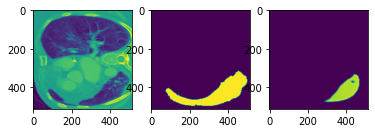

Epoch [2/10]   Batch 700   Loss: 0.8673    Max: 0.7417


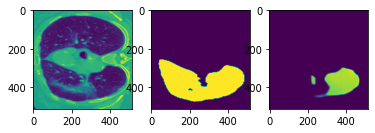

Epoch [2/10]   Batch 750   Loss: 8.4275    Max: 0.0006


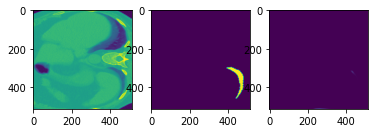

Epoch [2/10]   Batch 800   Loss: 0.6444    Max: 0.8620


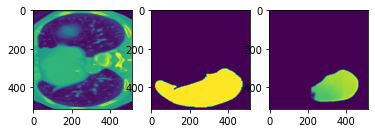

Epoch [2/10]   Batch 850   Loss: 0.3628    Max: 0.9988


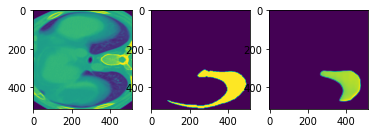

Epoch [2/10]   Batch 900   Loss: 1.3267    Max: 0.7113


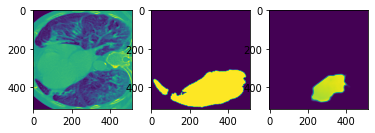

Epoch [2/10]   Batch 950   Loss: 0.4681    Max: 0.9961


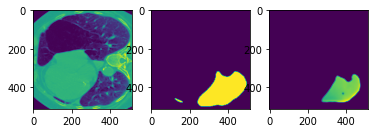

Epoch [2/10]   Batch 1000   Loss: 0.4754    Max: 0.9958


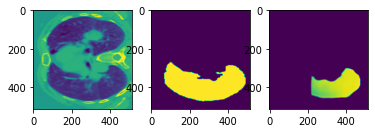

Epoch [2/10]   Batch 1050   Loss: 0.5640    Max: 0.9993


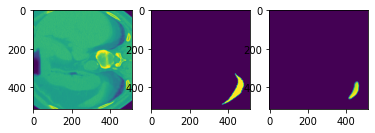

Epoch [2/10]   Batch 1100   Loss: 7.2041    Max: 0.0087


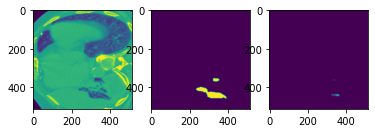

Epoch [2/10]   Batch 1150   Loss: 0.6214    Max: 0.9487


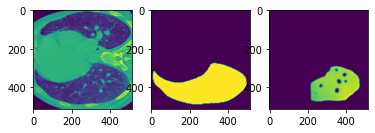

Epoch [2/10]   Batch 1200   Loss: 0.1673    Max: 0.9635


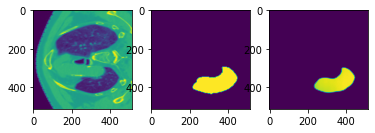

Epoch [2/10]   Batch 1208   Loss: 2.2532    lr: 0.0000050000
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
-------------------------
Epoch [2/10]   Dice Metric: 0.6900  IoU Metric: 0.5979  MSD Metric: inf  
  HD95 Metric: 421.0577  Precision Metric: 0.5985  Recall Metric: 0.3760


Epoch [3/10]   Batch 0   Loss: 6.2802    Max: 0.8975


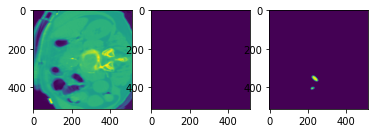

Epoch [3/10]   Batch 50   Loss: 0.4552    Max: 0.9867


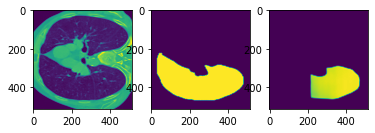

Epoch [3/10]   Batch 100   Loss: 5.7242    Max: 0.8992


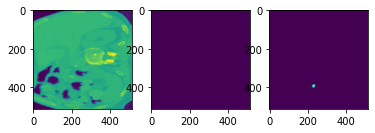

Epoch [3/10]   Batch 150   Loss: 0.0000    Max: 0.0000


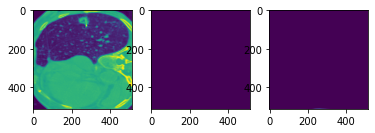

Epoch [3/10]   Batch 200   Loss: 0.0002    Max: 0.0000


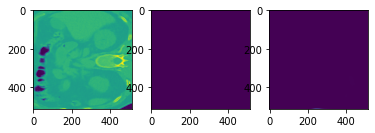

Epoch [3/10]   Batch 250   Loss: 0.5126    Max: 0.9922


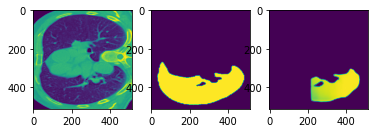

Epoch [3/10]   Batch 300   Loss: 0.3436    Max: 0.9964


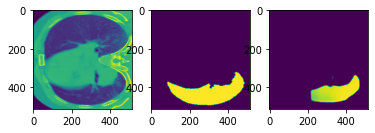

Epoch [3/10]   Batch 350   Loss: 0.3914    Max: 0.9888


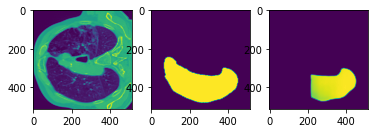

Epoch [3/10]   Batch 400   Loss: 0.4520    Max: 0.9844


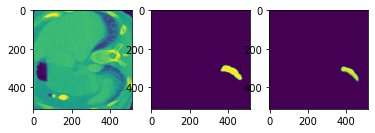

Epoch [3/10]   Batch 450   Loss: 0.4458    Max: 0.9952


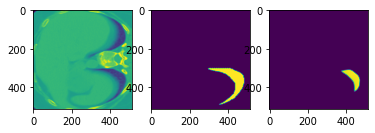

Epoch [3/10]   Batch 500   Loss: 7.8837    Max: 0.9905


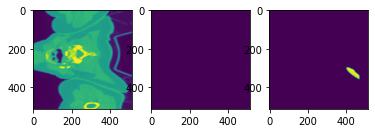

Epoch [3/10]   Batch 550   Loss: 1.7682    Max: 0.9888


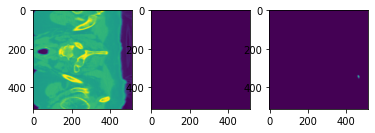

Epoch [3/10]   Batch 600   Loss: 0.0002    Max: 0.0000


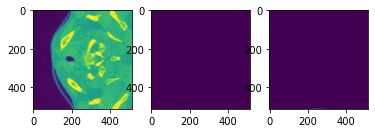

Epoch [3/10]   Batch 650   Loss: 0.4226    Max: 0.9997


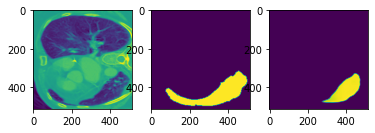

Epoch [3/10]   Batch 700   Loss: 0.4089    Max: 0.9989


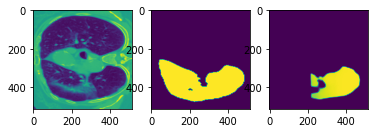

Epoch [3/10]   Batch 750   Loss: 1.6270    Max: 0.9853


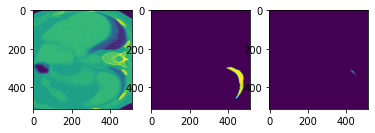

Epoch [3/10]   Batch 800   Loss: 0.3387    Max: 0.9998


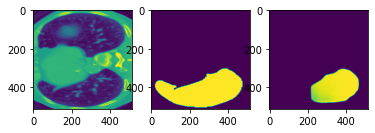

Epoch [3/10]   Batch 850   Loss: 0.3099    Max: 0.9998


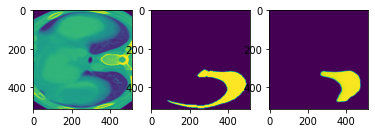

Epoch [3/10]   Batch 900   Loss: 0.3038    Max: 0.9992


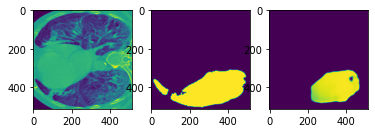

Epoch [3/10]   Batch 950   Loss: 0.1839    Max: 1.0000


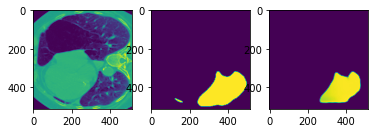

Epoch [3/10]   Batch 1000   Loss: 0.3602    Max: 0.9999


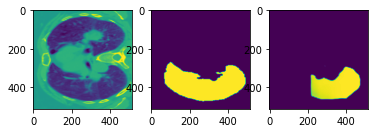

Epoch [3/10]   Batch 1050   Loss: 0.6660    Max: 0.9983


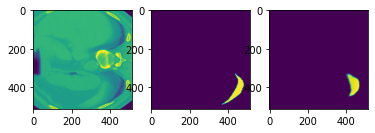

Epoch [3/10]   Batch 1100   Loss: 0.6041    Max: 0.9858


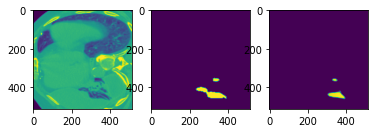

Epoch [3/10]   Batch 1150   Loss: 0.3213    Max: 0.9997


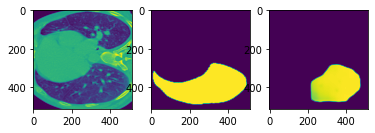

Epoch [3/10]   Batch 1200   Loss: 0.0977    Max: 0.9987


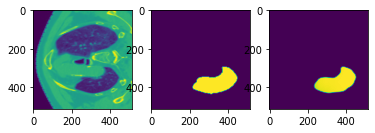

Epoch [3/10]   Batch 1208   Loss: 1.0979    lr: 0.0000005000
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
-------------------------
Epoch [3/10]   Dice Metric: 0.7150  IoU Metric: 0.6276  MSD Metric: inf  
  HD95 Metric: 424.0558  Precision Metric: 0.5845  Recall Metric: 0.3927


Epoch [4/10]   Batch 0   Loss: 6.2336    Max: 0.9581


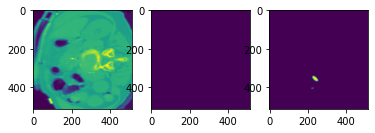

Epoch [4/10]   Batch 50   Loss: 0.4097    Max: 0.9996


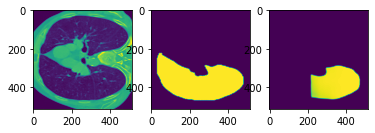

Epoch [4/10]   Batch 100   Loss: 5.8257    Max: 0.9721


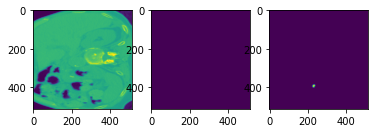

Epoch [4/10]   Batch 150   Loss: -0.0000    Max: 0.0000


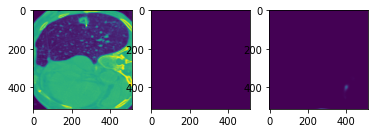

Epoch [4/10]   Batch 200   Loss: 0.0000    Max: 0.0000


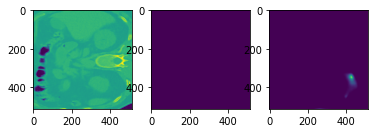

Epoch [4/10]   Batch 250   Loss: 0.4819    Max: 0.9999


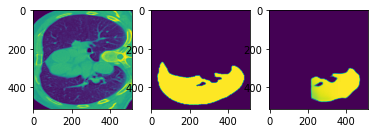

Epoch [4/10]   Batch 300   Loss: 0.3123    Max: 0.9997


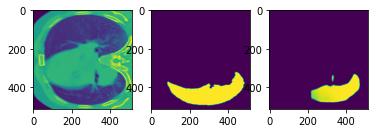

Epoch [4/10]   Batch 350   Loss: 0.3663    Max: 0.9995


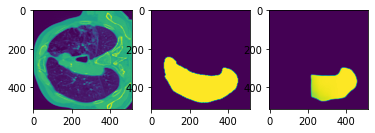

Epoch [4/10]   Batch 400   Loss: 0.3773    Max: 0.9989


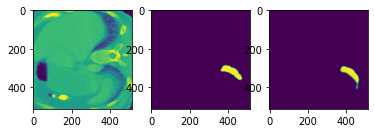

Epoch [4/10]   Batch 450   Loss: 0.3879    Max: 0.9991


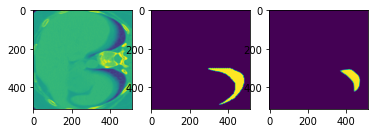

Epoch [4/10]   Batch 500   Loss: 8.0807    Max: 0.9994


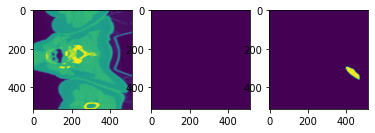

Epoch [4/10]   Batch 550   Loss: 2.1461    Max: 0.9976


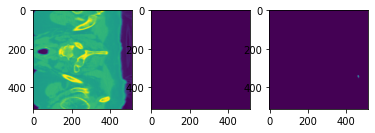

Epoch [4/10]   Batch 600   Loss: -0.0000    Max: 0.0000


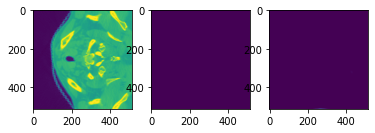

Epoch [4/10]   Batch 650   Loss: 0.4060    Max: 1.0000


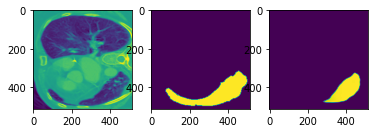

Epoch [4/10]   Batch 700   Loss: 0.3903    Max: 1.0000


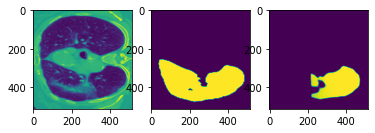

Epoch [4/10]   Batch 750   Loss: 1.2247    Max: 0.9979


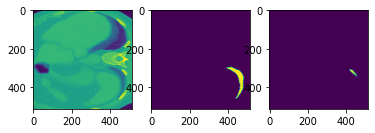

Epoch [4/10]   Batch 800   Loss: 0.3318    Max: 1.0000


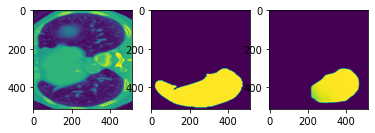

Epoch [4/10]   Batch 850   Loss: 0.3015    Max: 1.0000


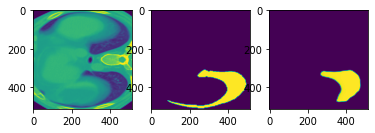

Epoch [4/10]   Batch 900   Loss: 0.2933    Max: 0.9999


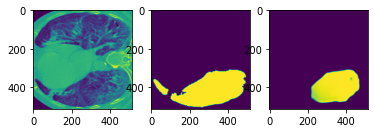

Epoch [4/10]   Batch 950   Loss: 0.1793    Max: 1.0000


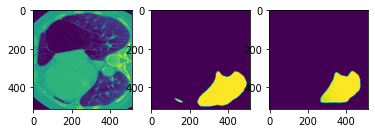

Epoch [4/10]   Batch 1000   Loss: 0.3553    Max: 1.0000


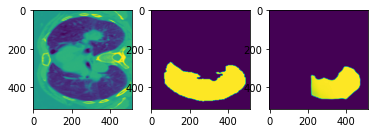

Epoch [4/10]   Batch 1050   Loss: 0.6585    Max: 0.9995


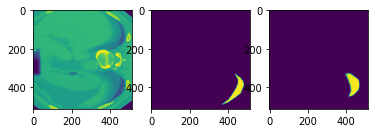

Epoch [4/10]   Batch 1100   Loss: 0.7134    Max: 0.9956


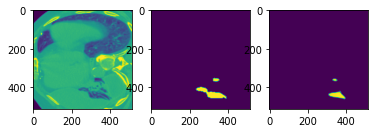

Epoch [4/10]   Batch 1150   Loss: 0.3077    Max: 1.0000


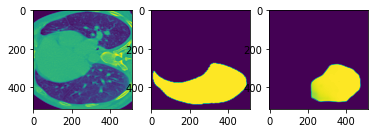

Epoch [4/10]   Batch 1200   Loss: 0.0988    Max: 0.9999


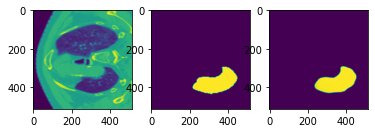

Epoch [4/10]   Batch 1208   Loss: 0.5378    lr: 0.0000005000
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
-------------------------
Epoch [4/10]   Dice Metric: 0.7188  IoU Metric: 0.6310  MSD Metric: inf  
  HD95 Metric: 431.3794  Precision Metric: 0.5761  Recall Metric: 0.3929


Epoch [5/10]   Batch 0   Loss: 5.8566    Max: 0.9714


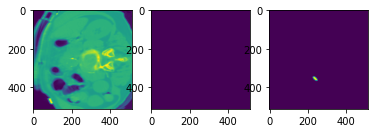

Epoch [5/10]   Batch 50   Loss: 0.4046    Max: 1.0000


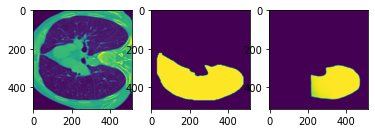

Epoch [5/10]   Batch 100   Loss: 3.2023    Max: 0.9820


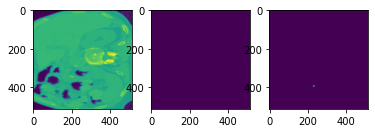

Epoch [5/10]   Batch 150   Loss: -0.0000    Max: 0.0000


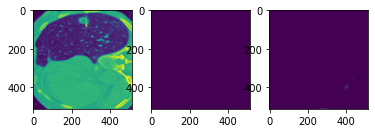

Epoch [5/10]   Batch 200   Loss: -0.0000    Max: 0.0000


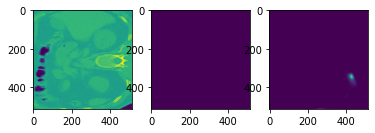

Epoch [5/10]   Batch 250   Loss: 0.4869    Max: 1.0000


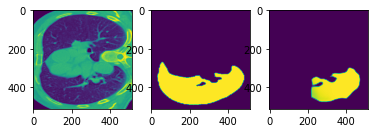

Epoch [5/10]   Batch 300   Loss: 0.3075    Max: 0.9999


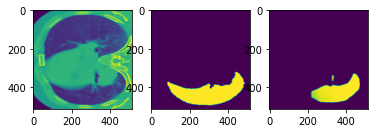

Epoch [5/10]   Batch 350   Loss: 0.3677    Max: 1.0000


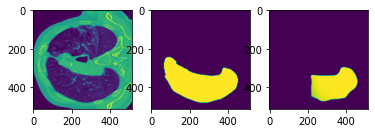

Epoch [5/10]   Batch 400   Loss: 0.3553    Max: 0.9999


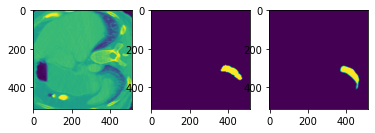

Epoch [5/10]   Batch 450   Loss: 0.3568    Max: 0.9999


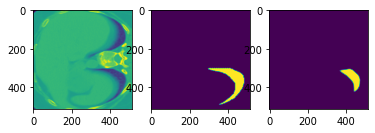

Epoch [5/10]   Batch 500   Loss: 8.1821    Max: 0.9999


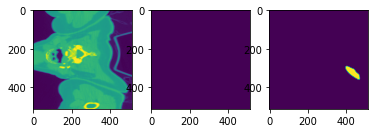

Epoch [5/10]   Batch 550   Loss: 1.7719    Max: 0.9994


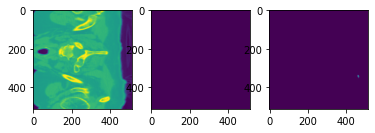

Epoch [5/10]   Batch 600   Loss: -0.0000    Max: 0.0000


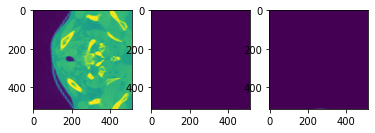

Epoch [5/10]   Batch 650   Loss: 0.3922    Max: 1.0000


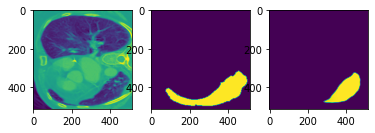

Epoch [5/10]   Batch 700   Loss: 0.3898    Max: 1.0000


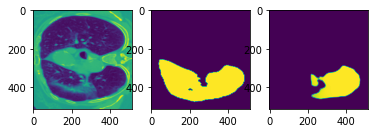

Epoch [5/10]   Batch 750   Loss: 0.9669    Max: 0.9998


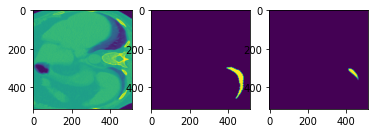

Epoch [5/10]   Batch 800   Loss: 0.3266    Max: 1.0000


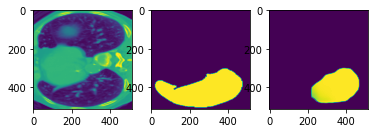

Epoch [5/10]   Batch 850   Loss: 0.2937    Max: 1.0000


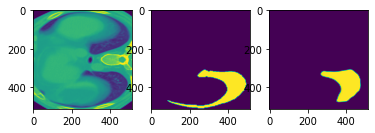

Epoch [5/10]   Batch 900   Loss: 0.2881    Max: 1.0000


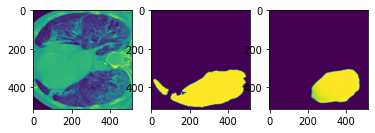

Epoch [5/10]   Batch 950   Loss: 0.1729    Max: 1.0000


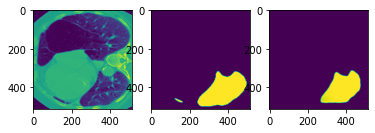

Epoch [5/10]   Batch 1000   Loss: 0.3577    Max: 1.0000


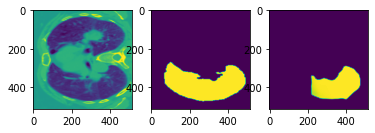

Epoch [5/10]   Batch 1050   Loss: 0.6343    Max: 0.9998


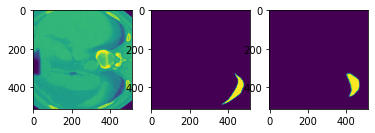

Epoch [5/10]   Batch 1100   Loss: 0.7833    Max: 0.9984


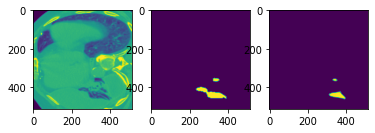

Epoch [5/10]   Batch 1150   Loss: 0.2953    Max: 1.0000


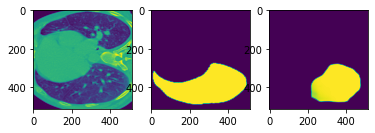

Epoch [5/10]   Batch 1200   Loss: 0.1064    Max: 1.0000


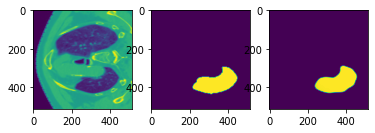

Epoch [5/10]   Batch 1208   Loss: 0.1546    lr: 0.0000005000
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
-------------------------
Epoch [5/10]   Dice Metric: 0.7187  IoU Metric: 0.6305  MSD Metric: inf  
  HD95 Metric: 434.6903  Precision Metric: 0.5696  Recall Metric: 0.3958


Epoch [6/10]   Batch 0   Loss: 5.4820    Max: 0.9781


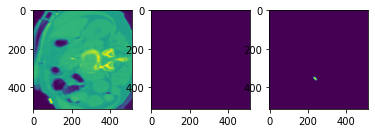

Epoch [6/10]   Batch 50   Loss: 0.4061    Max: 1.0000


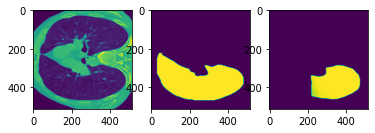

Epoch [6/10]   Batch 100   Loss: 1.5835    Max: 0.9786


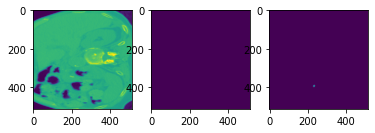

Epoch [6/10]   Batch 150   Loss: -0.0000    Max: 0.0000


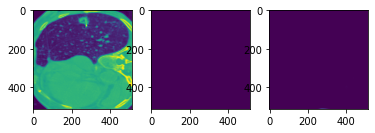

Epoch [6/10]   Batch 200   Loss: -0.0000    Max: 0.0000


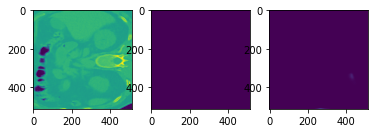

Epoch [6/10]   Batch 250   Loss: 0.4996    Max: 1.0000


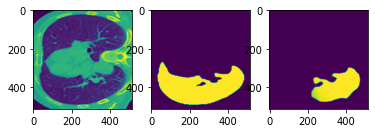

Epoch [6/10]   Batch 300   Loss: 0.3081    Max: 1.0000


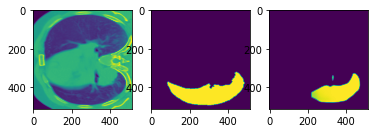

Epoch [6/10]   Batch 350   Loss: 0.3768    Max: 1.0000


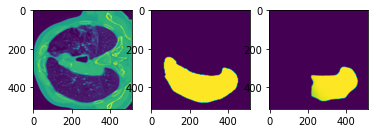

Epoch [6/10]   Batch 400   Loss: 0.3169    Max: 1.0000


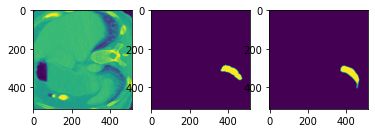

Epoch [6/10]   Batch 450   Loss: 0.3484    Max: 1.0000


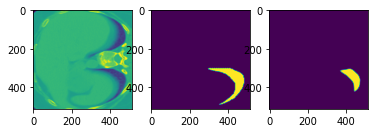

Epoch [6/10]   Batch 500   Loss: 8.2127    Max: 1.0000


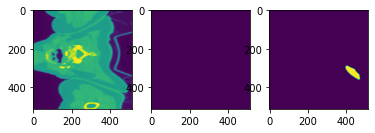

Epoch [6/10]   Batch 550   Loss: 1.6039    Max: 0.9995


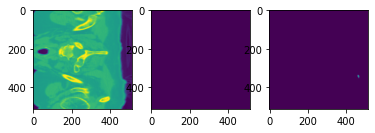

Epoch [6/10]   Batch 600   Loss: -0.0000    Max: 0.0000


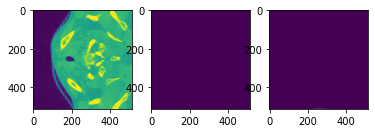

Epoch [6/10]   Batch 650   Loss: 0.4044    Max: 1.0000


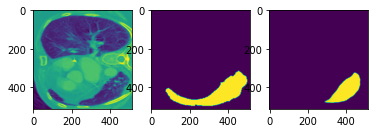

Epoch [6/10]   Batch 700   Loss: 0.4017    Max: 1.0000


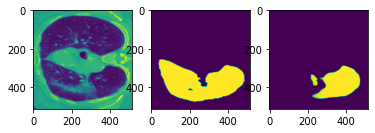

Epoch [6/10]   Batch 750   Loss: 1.1926    Max: 0.9998


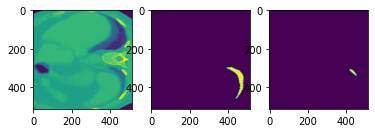

Epoch [6/10]   Batch 800   Loss: 0.3239    Max: 1.0000


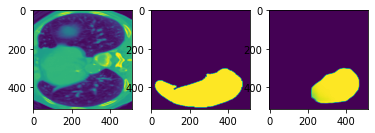

Epoch [6/10]   Batch 850   Loss: 0.2905    Max: 1.0000


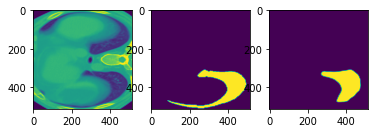

Epoch [6/10]   Batch 900   Loss: 0.2838    Max: 1.0000


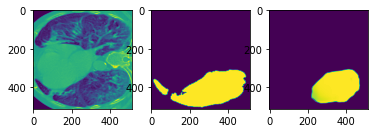

KeyboardInterrupt: 

In [15]:
fit(model=model, img_size=img_size, seg_organ=seg_organ, window_size=window_size,
    loss_fn=loss_fn, optimizer=optimizer, scheduler=scheduler,
    epochs=epochs, train_df=train_df, test_df=test_df, 
    validate=True, print_every=1)

In [ ]:
torch.save(model.state_dict(), 'lung_l')